<a href="https://colab.research.google.com/github/mickey2798/CouponRedemptionMateLabs/blob/master/Coupon_Redemption_Mate_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1p2g0LIC1lPV7i36mGudfSuP9CJu3LZM2'

In [ ]:
fluff, id = link.split('=')
print (id)

1p2g0LIC1lPV7i36mGudfSuP9CJu3LZM2


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data_matelabs.zip') 

In [ ]:
!ls

adc.json  data_matelabs.zip  sample_data


In [ ]:
!unzip data_matelabs.zip

Archive:  data_matelabs.zip
   creating: data/
  inflating: data/campaign_data.csv  
  inflating: data/coupon_item_mapping.csv  
  inflating: data/customer_demographics.csv  
  inflating: data/customer_transaction_data.csv  
  inflating: data/item_data.csv      
  inflating: data/train.csv          


In [ ]:
import os
os.chdir('data')

In [ ]:
#Importing all the necessary Libraries
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, recall_score, precision_score,make_scorer,classification_report,roc_curve
import xgboost as xgb
import os
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
##Loading all the CSV Files
train = pd.read_csv('train.csv')
coupon_item_mapping = pd.read_csv('coupon_item_mapping.csv')
item_data  = pd.read_csv('item_data.csv')
customer_demo = pd.read_csv('customer_demographics.csv')
customer_trans= pd.read_csv('customer_transaction_data.csv')
campaign_data = pd.read_csv('campaign_data.csv')

In [ ]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [ ]:
train.shape

(78369, 5)

In [ ]:
coupon_item_mapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [ ]:
coupon_item_mapping.shape

(92663, 2)

In [ ]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [ ]:
customer_demo.shape

(760, 7)

In [ ]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [ ]:
campaign_data.shape

(28, 4)

In [ ]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [ ]:
customer_trans.shape

(1324566, 7)

In [ ]:
#Adding a new column to get the actual price.
customer_trans['actual_price'] = customer_trans['selling_price'] - customer_trans['other_discount'] - customer_trans['coupon_discount']

In [ ]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,actual_price
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,45.95
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,67.32
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,120.75
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,67.32
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,99.38


In [ ]:
customer_demo['no_of_children'].fillna(0, inplace=True)
customer_demo['marital_status'].fillna('other', inplace=True)

In [ ]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,0,4
1,6,46-55,Married,0,2,0,5
2,7,26-35,other,0,3,1,3
3,8,26-35,other,0,4,2,6
4,10,46-55,Single,0,1,0,5


In [ ]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={
    'quantity':num_agg, 'selling_price':num_agg, 'other_discount':num_agg,'coupon_discount':num_agg,
       'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg, 'age_range':cat_agg, 'marital_status':cat_agg,
    'rented':cat_agg, 'family_size':cat_agg, 'no_of_children':cat_agg, 'income_bracket':cat_agg
}
customer_trans = customer_trans.merge(item_data,how='left',on='item_id').merge(customer_demo,how='left',on='customer_id').groupby('customer_id').agg(agg_col).reset_index()

In [ ]:
cat_agg=['count','nunique']
num_agg=['min','max','mean','sum']
agg_col={ 'brand':cat_agg, 'brand_type':cat_agg, 'category':cat_agg
}
coupon_item= coupon_item_mapping.merge(item_data,how='left',on='item_id').groupby('coupon_id').agg(agg_col).reset_index()

In [ ]:
def merge_df(df):
  df = df.merge(campaign_data, on='campaign_id', how='left')
  df = df.merge(coupon_item, on='coupon_id', how='left')
  df = df.merge(customer_trans, on='customer_id', how='left')
  return df


In [ ]:
train_df = merge_df(train.copy())

In [ ]:
train_df['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [ ]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x","('brand_type', 'count')_x","('brand_type', 'nunique')_x","('category', 'count')_x","('category', 'nunique')_x","(quantity, min)","(quantity, max)","(quantity, mean)","(quantity, sum)","(selling_price, min)","(selling_price, max)","(selling_price, mean)","(selling_price, sum)","(other_discount, min)","(other_discount, max)","(other_discount, mean)","(other_discount, sum)","(coupon_discount, min)","(coupon_discount, max)","(coupon_discount, mean)","(coupon_discount, sum)","(brand_y, count)","(brand_y, nunique)","(brand_type_y, count)","(brand_type_y, nunique)","(category_y, count)","(category_y, nunique)","(age_range, count)","(age_range, nunique)","(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,X,19/05/13,05/07/13,125,2,125,1,125,1,1,12444,340.487097,105551,17.45,5164.54,184.260484,57120.75,-890.50,0.0,-33.168935,-10282.37,-89.05,0.0,-0.287258,-89.05,310,84,310,2,310,8,310,1,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,X,19/05/13,05/07/13,3,1,3,1,3,1,1,11586,31.540260,12143,7.12,1758.92,234.247013,90185.10,-372.23,0.0,-27.699169,-10664.18,-213.72,0.0,-3.215039,-1237.79,385,102,385,2,385,12,385,1,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,Y,11/03/13,12/04/13,67,1,67,1,67,1,1,10,1.392784,1351,17.45,1056.13,121.094495,117461.66,-468.05,0.0,-17.795660,-17261.79,-89.05,0.0,-2.212082,-2145.72,970,186,970,2,970,11,970,1,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,X,19/05/13,05/07/13,4,1,4,1,4,1,1,5,1.291139,306,13.89,708.48,98.276034,23291.42,-312.03,0.0,-16.655570,-3947.37,-89.05,0.0,-0.751477,-178.10,237,73,237,2,237,8,0,0,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,X,16/02/13,05/04/13,32,1,32,1,32,1,1,15420,247.443060,139063,8.90,1424.80,120.636103,67797.49,-320.22,0.0,-20.524733,-11534.90,-53.43,0.0,-0.471548,-265.01,562,106,562,2,562,8,562,1,562,1,562,1,562,1,562,1,562,1


In [ ]:
##Label Encoding the categorical features
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
for i in train.columns:
  train_df['campaign_type'] = lb.fit_transform(train_df['campaign_type'])


In [ ]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x","('brand_type', 'count')_x","('brand_type', 'nunique')_x","('category', 'count')_x","('category', 'nunique')_x","(quantity, min)","(quantity, max)","(quantity, mean)","(quantity, sum)","(selling_price, min)","(selling_price, max)","(selling_price, mean)","(selling_price, sum)","(other_discount, min)","(other_discount, max)","(other_discount, mean)","(other_discount, sum)","(coupon_discount, min)","(coupon_discount, max)","(coupon_discount, mean)","(coupon_discount, sum)","(brand_y, count)","(brand_y, nunique)","(brand_type_y, count)","(brand_type_y, nunique)","(category_y, count)","(category_y, nunique)","(age_range, count)","(age_range, nunique)","(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)"
0,1,13,27,1053,0,0,19/05/13,05/07/13,125,2,125,1,125,1,1,12444,340.487097,105551,17.45,5164.54,184.260484,57120.75,-890.50,0.0,-33.168935,-10282.37,-89.05,0.0,-0.287258,-89.05,310,84,310,2,310,8,310,1,310,1,310,1,310,1,310,1,310,1
1,2,13,116,48,0,0,19/05/13,05/07/13,3,1,3,1,3,1,1,11586,31.540260,12143,7.12,1758.92,234.247013,90185.10,-372.23,0.0,-27.699169,-10664.18,-213.72,0.0,-3.215039,-1237.79,385,102,385,2,385,12,385,1,385,1,385,1,385,1,385,1,385,1
2,6,9,635,205,0,1,11/03/13,12/04/13,67,1,67,1,67,1,1,10,1.392784,1351,17.45,1056.13,121.094495,117461.66,-468.05,0.0,-17.795660,-17261.79,-89.05,0.0,-2.212082,-2145.72,970,186,970,2,970,11,970,1,970,1,970,1,970,1,970,1,970,1
3,7,13,644,1050,0,0,19/05/13,05/07/13,4,1,4,1,4,1,1,5,1.291139,306,13.89,708.48,98.276034,23291.42,-312.03,0.0,-16.655570,-3947.37,-89.05,0.0,-0.751477,-178.10,237,73,237,2,237,8,0,0,0,0,0,0,0,0,0,0,0,0
4,9,8,1017,1489,0,0,16/02/13,05/04/13,32,1,32,1,32,1,1,15420,247.443060,139063,8.90,1424.80,120.636103,67797.49,-320.22,0.0,-20.524733,-11534.90,-53.43,0.0,-0.471548,-265.01,562,106,562,2,562,8,562,1,562,1,562,1,562,1,562,1,562,1


In [ ]:
##Checking for the null values in the train_df
train_df.isnull().sum(axis=0)

id                             0
campaign_id                    0
coupon_id                      0
customer_id                    0
redemption_status              0
campaign_type                  0
start_date                     0
end_date                       0
('brand', 'count')_x           0
('brand', 'nunique')_x         0
('brand_type', 'count')_x      0
('brand_type', 'nunique')_x    0
('category', 'count')_x        0
('category', 'nunique')_x      0
(quantity, min)                0
(quantity, max)                0
(quantity, mean)               0
(quantity, sum)                0
(selling_price, min)           0
(selling_price, max)           0
(selling_price, mean)          0
(selling_price, sum)           0
(other_discount, min)          0
(other_discount, max)          0
(other_discount, mean)         0
(other_discount, sum)          0
(coupon_discount, min)         0
(coupon_discount, max)         0
(coupon_discount, mean)        0
(coupon_discount, sum)         0
(brand_y, 

In [ ]:
len(train_df.columns)

48

In [ ]:
for col in train_df.columns:
  if len(train_df[col].unique()) == 1:
    print(train_df[col])
    train_df.drop(col, inplace=True, axis=1)

0        1
1        1
2        1
3        1
4        1
        ..
78364    1
78365    1
78366    1
78367    1
78368    1
Name: (quantity, min), Length: 78369, dtype: int64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
78364    0.0
78365    0.0
78366    0.0
78367    0.0
78368    0.0
Name: (other_discount, max), Length: 78369, dtype: float64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
78364    0.0
78365    0.0
78366    0.0
78367    0.0
78368    0.0
Name: (coupon_discount, max), Length: 78369, dtype: float64
0        2
1        2
2        2
3        2
4        2
        ..
78364    2
78365    2
78366    2
78367    2
78368    2
Name: (brand_type_y, nunique), Length: 78369, dtype: int64


In [ ]:
len(train_df.columns)


44

In [ ]:
print(type(train_df['start_date'][0]))
print(type(train_df['start_date'][0]))


<class 'str'>
<class 'str'>


In [ ]:
#As the start date and end date are from class 'str', the very first this to convert it to timestamp
train_df['start_date'] = pd.to_datetime(train_df['start_date'], format='%d/%m/%y')
train_df['end_date'] = pd.to_datetime(train_df['end_date'], format='%d/%m/%y')


In [ ]:
print(type(train_df['start_date'][0]))
print(type(train_df['start_date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
train_df["campaign_month"] = train_df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)
train_df['campaign_duration'] = (train_df['end_date'] - train_df['start_date'])
train_df['campaign_duration'] = train_df['campaign_duration'].apply(lambda x: x.days)


In [ ]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,campaign_type,start_date,end_date,"('brand', 'count')_x","('brand', 'nunique')_x","('brand_type', 'count')_x","('brand_type', 'nunique')_x","('category', 'count')_x","('category', 'nunique')_x","(quantity, max)","(quantity, mean)","(quantity, sum)","(selling_price, min)","(selling_price, max)","(selling_price, mean)","(selling_price, sum)","(other_discount, min)","(other_discount, mean)","(other_discount, sum)","(coupon_discount, min)","(coupon_discount, mean)","(coupon_discount, sum)","(brand_y, count)","(brand_y, nunique)","(brand_type_y, count)","(category_y, count)","(category_y, nunique)","(age_range, count)","(age_range, nunique)","(marital_status, count)","(marital_status, nunique)","(rented, count)","(rented, nunique)","(family_size, count)","(family_size, nunique)","(no_of_children, count)","(no_of_children, nunique)","(income_bracket, count)","(income_bracket, nunique)",campaign_month,campaign_duration
0,1,13,27,1053,0,0,2013-05-19,2013-07-05,125,2,125,1,125,1,12444,340.487097,105551,17.45,5164.54,184.260484,57120.75,-890.50,-33.168935,-10282.37,-89.05,-0.287258,-89.05,310,84,310,310,8,310,1,310,1,310,1,310,1,310,1,310,1,2,47
1,2,13,116,48,0,0,2013-05-19,2013-07-05,3,1,3,1,3,1,11586,31.540260,12143,7.12,1758.92,234.247013,90185.10,-372.23,-27.699169,-10664.18,-213.72,-3.215039,-1237.79,385,102,385,385,12,385,1,385,1,385,1,385,1,385,1,385,1,2,47
2,6,9,635,205,0,1,2013-03-11,2013-04-12,67,1,67,1,67,1,10,1.392784,1351,17.45,1056.13,121.094495,117461.66,-468.05,-17.795660,-17261.79,-89.05,-2.212082,-2145.72,970,186,970,970,11,970,1,970,1,970,1,970,1,970,1,970,1,2,32
3,7,13,644,1050,0,0,2013-05-19,2013-07-05,4,1,4,1,4,1,5,1.291139,306,13.89,708.48,98.276034,23291.42,-312.03,-16.655570,-3947.37,-89.05,-0.751477,-178.10,237,73,237,237,8,0,0,0,0,0,0,0,0,0,0,0,0,2,47
4,9,8,1017,1489,0,0,2013-02-16,2013-04-05,32,1,32,1,32,1,15420,247.443060,139063,8.90,1424.80,120.636103,67797.49,-320.22,-20.524733,-11534.90,-53.43,-0.471548,-265.01,562,106,562,562,8,562,1,562,1,562,1,562,1,562,1,562,1,1,48


In [ ]:
features_name = [x for x in train_df.columns if x not in ['id' , 'redemption_status', 'start_date', 'end_date']]
target = train_df['redemption_status']

In [ ]:
len(features_name), len(target)

(42, 78369)

Accuracy:  0.9899834120199056
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15528
           1       0.35      0.09      0.14       146

    accuracy                           0.99     15674
   macro avg       0.67      0.54      0.57     15674
weighted avg       0.99      0.99      0.99     15674

AUROC Plot: 0.8511


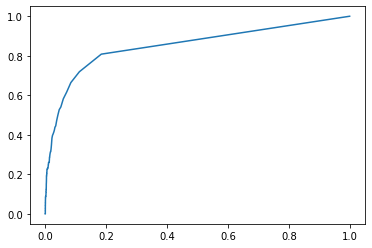

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features_name].values, target, test_size=0.2, random_state=2019,stratify=target)
model=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

Accuracy:  0.9908128110246268
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15528
           1       0.75      0.02      0.04       146

    accuracy                           0.99     15674
   macro avg       0.87      0.51      0.52     15674
weighted avg       0.99      0.99      0.99     15674

AUROC Plot: 0.9295


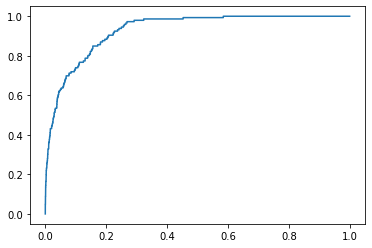

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features_name].values, target, test_size=0.2, random_state=2019,stratify=target)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

Accuracy:  0.9900472119433457
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15528
           1       0.38      0.10      0.16       146

    accuracy                           0.99     15674
   macro avg       0.68      0.55      0.58     15674
weighted avg       0.99      0.99      0.99     15674

AUROC Plot: 0.8504


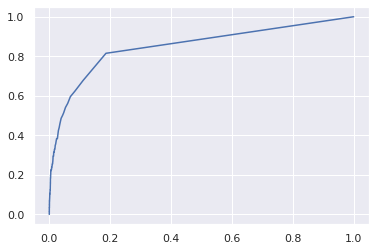

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features_name].values, target, test_size=0.2, random_state=2019,stratify=target)
model=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print("Accuracy: ",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC ROC CURVE
predictions = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred, average='weighted')

fpr, tpr, threshold = roc_curve(y_test, predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("AUROC Plot:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()